Let's start with a classical least-squares problem. We take the example problem from  [*scipy.stats.linregress*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress), since we will also use it for comparison.

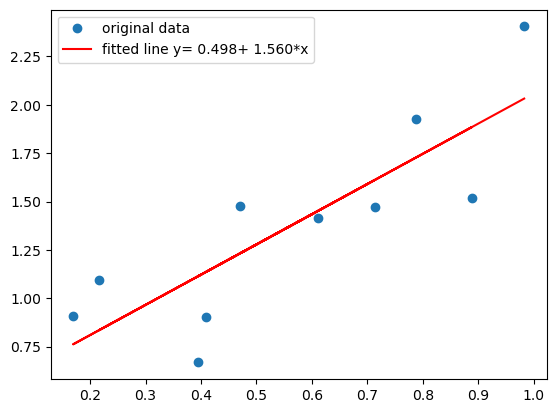

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
rng = np.random.default_rng()
x = rng.random(10)
y = 1.6*x + rng.random(10)
res = stats.linregress(x, y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label=f'fitted line y={res.intercept:6.3f}+{res.slope:6.3f}*x')
plt.legend()
plt.show()

Remember that in this problem we are only looking for the two parameters $a$ (the intercept) a,d $b$ (the slope), such that the square of residuals (distances between prediction of our affine model and the data)
$$
L_2(a,b) = \frac12\sum_{i=1}^n r_i^2, \quad r_i := (a+bx_i) - y_i
$$
is minimized. This is a convex quadratic function, such that we can solve for $\nabla L_2(a,b)=0$ ($\nabla$ with respect to $a$ and $b$). Since 
$
\frac{\partial L_2}{\partial a} = \sum_{i=1}^n r_i\frac{\partial r_i}{\partial a},
$
similarly for the other derivative,
$\frac{\partial r_i}{\partial a} = 1$, and $\frac{\partial r_i}{\partial b} = x_i$, we have
$$
0 = \sum_{i=1}^nr_i = \sum_{i=1}^n (a+bx_i) - y_i\quad\text{and}\quad 0 = \sum_{i=1}^nr_ix_i =\sum_{i=1}^n ((a+bx_i) - y_i)x_i=0,
$$
which reads with $\overline{x}:=\frac1n\sum_{i=1}^n x_i$ and $\overline{y}:=\frac1n\sum_{i=1}^n y_i$
$$
A \begin{pmatrix}a\\b\end{pmatrix}= \begin{pmatrix}c\\d\end{pmatrix}
$$
with
$$
A = \begin{pmatrix}1 & \overline{x}\\\overline{x}&\overline{x^2}\end{pmatrix},\quad
c = \overline{y},\quad\text{and}\quad\overline{xy}.
$$

Now let us look at $l_1$ minimization. We have
$$
L_1(a,b) =\sum_{i=1}^n |r_i|, \quad r_i := (a+bx_i) - y_i.
$$
The idea to transform this problem to a LP is by introducing variables $z_i$ for each residual $r_i$. If 
$$
z_i \ge r_i\quad \text{and}\quad  z_i\ge -r_i \quad\Longrightarrow\quad z_i \ge |r_i|.
$$
So with $e^T = (1,1;\cdots,1)$ (the vector of all ones) we can formulate
$$
\begin{align}
&\min e^Tz\quad\text{under the constraints}\\
&z_i \ge (a+bx_i) - y_i,\\
&z_i \ge y_i - (a+bx_i).
\end{align}
$$
The constraints be written as
$$
\begin{align}
\begin{pmatrix} I & -e & -x\\ I & e & x\end{pmatrix}
\begin{pmatrix} z\\a\\b\end{pmatrix}
\ge
\begin{pmatrix} -y\\y\end{pmatrix}
\end{align}
$$


Let us solve this problem with *scipy.linprog*:

In [5]:
from scipy import optimize
c = np.ones(12)
c[-2:]=0
# rearrange for linprog (taking only '<=' constraints)!
b = np.block([y,-y])
I, e = np.eye(10), np.ones(10).reshape(10,1)
A = np.block([[-I, e, x.reshape(10,1)],[-I, -e,-x.reshape(10,1)]])
#print(f"{b=}\\{c=}\\{A=}")
resultL1 = optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None,None))

Now we can compare the two results:

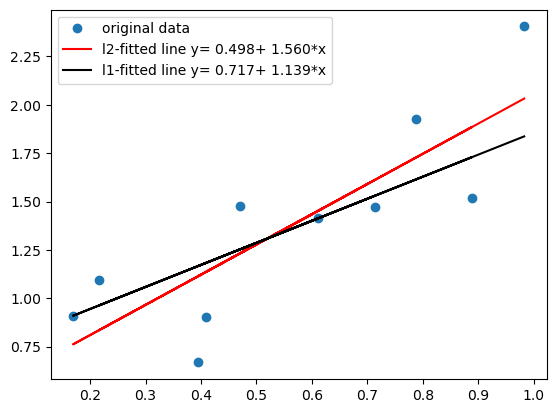

In [6]:
plt.plot(x, y, 'o', label='original data')
a,b = res.intercept, res.slope
plt.plot(x, a + b*x, 'r', label=f'l2-fitted line y={a:6.3f}+{b:6.3f}*x')
a,b = resultL1.x[-2], resultL1.x[-1]
plt.plot(x, a + b*x, 'k', label=f'l1-fitted line y={a:6.3f}+{b:6.3f}*x')
plt.legend()
plt.show()

Probably, this is not the fastest algorithm to solve the problem...but this is another question.

Let's have a look at different data, just changing the last measurment.

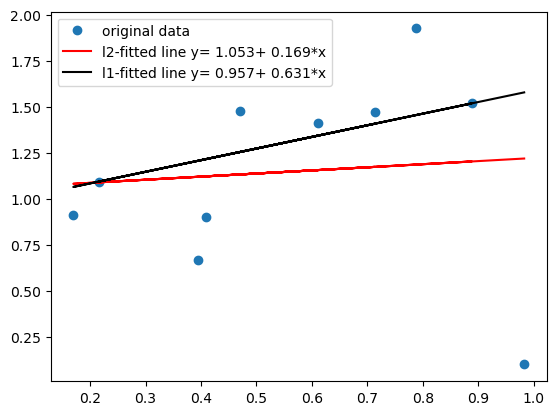

In [7]:
y[-1] = 0.1
b = np.block([y,-y])
A = np.block([[-np.eye(10), np.ones(10).reshape(10,1),x.reshape(10,1)],[-np.eye(10), -np.ones(10).reshape(10,1),-x.reshape(10,1)]])
resultL2 = stats.linregress(x, y)
resultL1 = optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None,None))

plt.plot(x, y, 'o', label='original data')
a,b = resultL2.intercept, resultL2.slope
plt.plot(x, a + b*x, 'r', label=f'l2-fitted line y={a:6.3f}+{b:6.3f}*x')
a,b = resultL1.x[-2], resultL1.x[-1]
plt.plot(x, a + b*x, 'k', label=f'l1-fitted line y={a:6.3f}+{b:6.3f}*x')
plt.legend()
plt.show()

We observe that the $l_1$-fit is less sensible than the $l_2$-fit to outlayers, data 'far away'.

Quite the opposite happens, if we minimize the residual in the $l_{\infty}$-norm. Again, this can be written as a LP:
$$
\min\left\{z \;\vert\; z \ge r_i \;\text{and}\; z\ge -r_i\; \forall i\right\},
$$
or in matrix notation
$$
\begin{aligned}
&\min z,\\
&ze - a e - b x \ge -y,\\ 
&ze + a e + b x \ge y. 
\end{aligned}
$$
So we can feed this to *scipy.linprog* and compare with the previous results.

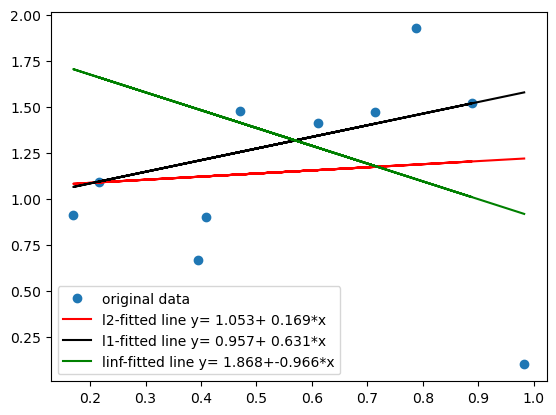

In [14]:
b = np.block([y,-y])
A = np.block([[-e, e, x.reshape(10,1)],[-e, -e,-x.reshape(10,1)]])
c = [1,0,0]
resultLinf = optimize.linprog(c, A_ub=A, b_ub=b, bounds=(None,None))
plt.plot(x, y, 'o', label='original data')
a,b = resultL2.intercept, resultL2.slope
plt.plot(x, a + b*x, 'r', label=f'l2-fitted line y={a:6.3f}+{b:6.3f}*x')
a,b = resultL1.x[-2], resultL1.x[-1]
plt.plot(x, a + b*x, 'k', label=f'l1-fitted line y={a:6.3f}+{b:6.3f}*x')
a,b = resultLinf.x[-2], resultLinf.x[-1]
plt.plot(x, a + b*x, 'g', label=f'linf-fitted line y={a:6.3f}+{b:6.3f}*x')
plt.legend()
plt.show()

Quite a change! Even the sign of the slope has changed.